# Assignment 3

Samih Amer

In [2]:
import sys 
import torch
import torch.utils.data
import torchvision
from torchvision import datasets, transforms
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
Device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f'PyTorch version= {torch.__version__}')
print(f'torchvision version= {torchvision.__version__}')
print(f'CUDA available= {torch.cuda.is_available()}')

PyTorch version= 2.7.1
torchvision version= 0.22.1
CUDA available= False


In [4]:
IMG_SIZE= 28
dataset = datasets.MNIST(root = '/Users/samihamer/Desktop/Advanced Applied AI Summer 2025/Module 3/MNIST',
                         train = True,
                         download = True,
                         transform = transforms.Compose([transforms.ToTensor(),
                                                         transforms.Resize([IMG_SIZE,IMG_SIZE], antialias=True),
                                                         transforms.Normalize((0.1307,), (0.3081,))]))

In [5]:
BATCH_SIZE = 256
Dloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)

In [6]:
ds = next(iter(torch.utils.data.DataLoader(dataset=dataset, batch_size=len(dataset), shuffle=True)))
X = ds[0].numpy().astype(np.float32).reshape(len(dataset),IMG_SIZE*IMG_SIZE)
print(X.shape, X.min(), X.max())

(60000, 784) -0.42421296 2.8214867


## Problem 1: Build a CNN autoencoder, convert the linear layers to CNN layers in the notebook implementation

In [8]:
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()

        # Encoder: Reduce spatial dimensions while increasing channels
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),   
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),  
            nn.ReLU(True)
        )

        # Decoder: Reconstruct original spatial dimensions
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),  
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
def train_autoencoder(model, dataloader, num_epochs=20, learning_rate=1e-3, device='cpu'):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, _ in dataloader:
            images = images.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, images)  # compare reconstructed image to original

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

In [10]:
model = CNNAutoencoder()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, _ in Dloader:
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(Dloader.dataset)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}")

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/20], Loss: 0.6410
Epoch [2/20], Loss: 0.4877
Epoch [3/20], Loss: 0.4783
Epoch [4/20], Loss: 0.4748
Epoch [5/20], Loss: 0.4729
Epoch [6/20], Loss: 0.4716
Epoch [7/20], Loss: 0.4707
Epoch [8/20], Loss: 0.4700
Epoch [9/20], Loss: 0.4694
Epoch [10/20], Loss: 0.4690
Epoch [11/20], Loss: 0.4686
Epoch [12/20], Loss: 0.4683
Epoch [13/20], Loss: 0.4680
Epoch [14/20], Loss: 0.4678
Epoch [15/20], Loss: 0.4676
Epoch [16/20], Loss: 0.4674
Epoch [17/20], Loss: 0.4672
Epoch [18/20], Loss: 0.4671
Epoch [19/20], Loss: 0.4669
Epoch [20/20], Loss: 0.4668


In [12]:
def visualize_reconstructions(model, dataloader, device='cpu', num_images=6):
    model.eval()
    model.to(device)

    with torch.no_grad():
        # Take one batch from the dataloader
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            break  

    images = images.cpu()
    outputs = outputs.cpu()

    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):

        axes[0, i].imshow(images[i][0], cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title("Original")


        axes[1, i].imshow(outputs[i][0], cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title("Reconstructed")

    plt.tight_layout()
    plt.show()

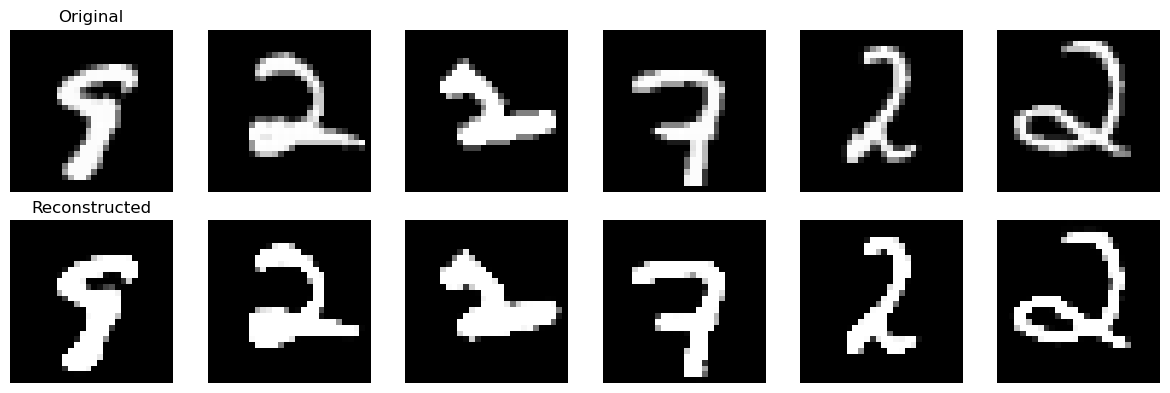

In [13]:
visualize_reconstructions(model, Dloader, device='cuda' if torch.cuda.is_available() else 'cpu')

## Problem 2: Empirically show that the CNN autoencoder features are more efficient in terms of size (you need fewer of them, i.e., smaller latent space size) and fitness (they approximate better, i.e., the error between input and output images is smaller). One possible way is to compute the total error while reducing the size of the latent space

In [15]:
class CNNAutoencoder(nn.Module):
    def __init__(self, latent_dim=8):
        super(CNNAutoencoder, self).__init__()

        # Convolutional encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),   # 28x28 → 14x14
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 14x14 → 7x7
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),  # 7x7 → 3x3
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten()
        self.fc_enc = nn.Linear(64 * 3 * 3, latent_dim)

        # Linear projection from latent space back to feature map
        self.fc_dec = nn.Linear(latent_dim, 64 * 3 * 3)

        # Convolutional decoder
        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),                                 # 3x3 → 7x7
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),    # 7x7 → 14x14
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),     # 14x14 → 28x28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder_cnn(x)           # [B, 64, 3, 3]
        x = self.flatten(x)               # [B, 576]
        z = self.fc_enc(x)                # [B, latent_dim]

        x = self.fc_dec(z)                # [B, 576]
        x = x.view(-1, 64, 3, 3)          # reshape back
        x = self.decoder_cnn(x)           # [B, 1, 28, 28]
        return x

In [16]:
latent_dims = [2, 4, 8, 16, 32]
results = []

for dim in latent_dims:
    print(f"\nTraining model with latent_dim = {dim}")
    model = CNNAutoencoder(latent_dim=dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in range(5):  
        model.train()
        total_loss = 0

        for images, _ in Dloader:
            images = images.to(device)

            outputs = model(images)
            loss = criterion(outputs, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(Dloader.dataset)
    print(f"Latent Dim: {dim}, Final Loss: {avg_loss:.4f}")
    results.append((dim, avg_loss))


Training model with latent_dim = 2
Latent Dim: 2, Final Loss: 0.7178

Training model with latent_dim = 4
Latent Dim: 4, Final Loss: 0.6169

Training model with latent_dim = 8
Latent Dim: 8, Final Loss: 0.5549

Training model with latent_dim = 16
Latent Dim: 16, Final Loss: 0.5190

Training model with latent_dim = 32
Latent Dim: 32, Final Loss: 0.4983


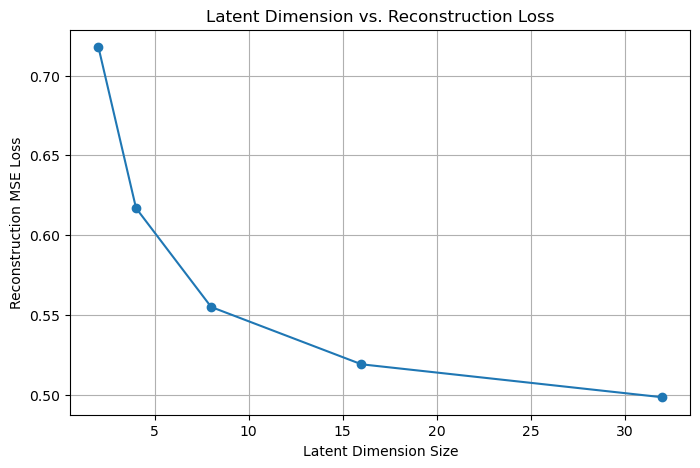

In [17]:
import matplotlib.pyplot as plt

dims, losses = zip(*results)
plt.figure(figsize=(8, 5))
plt.plot(dims, losses, marker='o')
plt.title('Latent Dimension vs. Reconstruction Loss')
plt.xlabel('Latent Dimension Size')
plt.ylabel('Reconstruction MSE Loss')
plt.grid(True)
plt.show()

## Problem 3: Compare autoencoders and variational autoencoders regarding feature representation and learning speed

#### Create MNIST dataset with values in [0,1] range for VAE 

In [20]:
def create_unnormalized_dataset():
    IMG_SIZE = 28
    dataset = datasets.MNIST(
        root='/Users/samihamer/Desktop/Advanced Applied AI Summer 2025/Module 3/MNIST',
        train=True,
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),  # This converts to [0,1] range
            transforms.Resize([IMG_SIZE, IMG_SIZE], antialias=True)
        ])
    )
    return dataset

In [21]:
class VAE(nn.Module):
    def __init__(self, latent_dim=8):
        super(VAE, self).__init__()
        
        # Encoder: CNN → Flatten → μ & log(σ²)
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),   # 28x28 → 14x14
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # 14x14 → 7x7
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=0),  # 7x7 → 3x3
            nn.ReLU(True)
        )
        
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(64 * 3 * 3, latent_dim)
        self.fc_logvar = nn.Linear(64 * 3 * 3, latent_dim)
        
        self.fc_dec = nn.Linear(latent_dim, 64 * 3 * 3)
        
        # Decoder: same as regular CNN decoder
        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Outputs [0,1] to match input range
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        
        x = self.fc_dec(z)
        x = x.view(-1, 64, 3, 3)
        x = self.decoder_cnn(x)
        return x, mu, logvar

#### VAE loss with proper scaling |  beta: weight for KL divergence (much smaller than 1.0)

In [23]:
def vae_loss(reconstructed, original, mu, logvar, beta=0.001):
    recon_loss = F.mse_loss(reconstructed, original, reduction='mean')
    
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
    total_loss = recon_loss + beta * kl_div
    
    return total_loss, recon_loss, kl_div

In [24]:
def train_vae(model, dataloader, epochs=10, beta=0.001, device='cpu'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    mse_history = []
    kl_history = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_mse = 0
        total_kl = 0
        num_batches = 0
        
        for images, _ in dataloader:
            images = images.to(device)
            reconstructed, mu, logvar = model(images)
            
            loss, mse, kl = vae_loss(reconstructed, images, mu, logvar, beta)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            total_mse += mse.item()
            total_kl += kl.item()
            num_batches += 1
        
        avg_loss = total_loss / num_batches
        avg_mse = total_mse / num_batches
        avg_kl = total_kl / num_batches
        
        mse_history.append(avg_mse)
        kl_history.append(avg_kl)
        
        print(f"[VAE] Epoch {epoch+1}, Total Loss: {avg_loss:.4f}, MSE: {avg_mse:.4f}, KL: {avg_kl:.4f}")
    
    return mse_history, kl_history

In [25]:
def train_cnn_autoencoder(model, dataloader, epochs=10, device='cpu'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    mse_history = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        num_batches = 0
        
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
        
        avg_loss = total_loss / num_batches
        mse_history.append(avg_loss)
        print(f"[AE] Epoch {epoch+1}, MSE: {avg_loss:.4f}")
    
    return mse_history

In [26]:
class CNNAutoencoderUnnormalized(nn.Module):
    def __init__(self, latent_dim=8):
        super(CNNAutoencoderUnnormalized, self).__init__()
        
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        self.flatten = nn.Flatten()
        self.fc_enc = nn.Linear(64 * 3 * 3, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, 64 * 3 * 3)
        
        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  
        )
    
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        z = self.fc_enc(x)
        x = self.fc_dec(z)
        x = x.view(-1, 64, 3, 3)
        x = self.decoder_cnn(x)
        return x


In [27]:
def compare_models():
    
    # Create unnormalized dataset for fair comparison
    unnormalized_dataset = create_unnormalized_dataset()
    BATCH_SIZE = 256
    unnormalized_loader = torch.utils.data.DataLoader(
        dataset=unnormalized_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        pin_memory=True, 
        num_workers=4
    )
    
    Z_DIM = 8
    EPOCHS = 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print("Training CNN Autoencoder (unnormalized data)...")
    cnn_model = CNNAutoencoderUnnormalized(latent_dim=Z_DIM)
    cnn_loss = train_cnn_autoencoder(cnn_model, unnormalized_loader, epochs=EPOCHS, device=device)
    
    print("\nTraining VAE...")
    vae_model = VAE(latent_dim=Z_DIM)
    vae_mse, vae_kl = train_vae(vae_model, unnormalized_loader, epochs=EPOCHS, beta=0.001, device=device)

    print(f"cnn_loss type: {type(cnn_loss)}, length: {len(cnn_loss) if cnn_loss else 'None'}")
    print(f"vae_mse type: {type(vae_mse)}, length: {len(vae_mse) if vae_mse else 'None'}")
    
    # Plot comparison
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    epochs_range = range(1, len(cnn_loss) + 1)
    plt.plot(epochs_range, cnn_loss, label='CNN Autoencoder MSE', marker='o')
    plt.plot(epochs_range, vae_mse, label='VAE MSE', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('MSE Comparison: CNN AE vs VAE')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, vae_kl, label='VAE KL Divergence', color='red', marker='^')
    plt.xlabel('Epoch')
    plt.ylabel('KL Divergence')
    plt.title('VAE KL Divergence Over Training')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFinal Results:")
    print(f"CNN Autoencoder final MSE: {cnn_loss[-1]:.4f}")
    print(f"VAE final MSE: {vae_mse[-1]:.4f}")
    print(f"VAE final KL: {vae_kl[-1]:.4f}")
    
    return cnn_model, vae_model, unnormalized_loader

Training CNN Autoencoder (unnormalized data)...
[AE] Epoch 1, MSE: 0.0776
[AE] Epoch 2, MSE: 0.0408
[AE] Epoch 3, MSE: 0.0290
[AE] Epoch 4, MSE: 0.0260
[AE] Epoch 5, MSE: 0.0244
[AE] Epoch 6, MSE: 0.0233
[AE] Epoch 7, MSE: 0.0225
[AE] Epoch 8, MSE: 0.0219
[AE] Epoch 9, MSE: 0.0214
[AE] Epoch 10, MSE: 0.0209

Training VAE...
[VAE] Epoch 1, Total Loss: 0.0810, MSE: 0.0788, KL: 2.1547
[VAE] Epoch 2, Total Loss: 0.0403, MSE: 0.0378, KL: 2.5239
[VAE] Epoch 3, Total Loss: 0.0295, MSE: 0.0268, KL: 2.7243
[VAE] Epoch 4, Total Loss: 0.0272, MSE: 0.0245, KL: 2.7311
[VAE] Epoch 5, Total Loss: 0.0259, MSE: 0.0232, KL: 2.7615
[VAE] Epoch 6, Total Loss: 0.0251, MSE: 0.0223, KL: 2.7763
[VAE] Epoch 7, Total Loss: 0.0245, MSE: 0.0217, KL: 2.7941
[VAE] Epoch 8, Total Loss: 0.0239, MSE: 0.0211, KL: 2.8028
[VAE] Epoch 9, Total Loss: 0.0235, MSE: 0.0207, KL: 2.8099
[VAE] Epoch 10, Total Loss: 0.0232, MSE: 0.0204, KL: 2.8120
cnn_loss type: <class 'list'>, length: 10
vae_mse type: <class 'list'>, length: 10


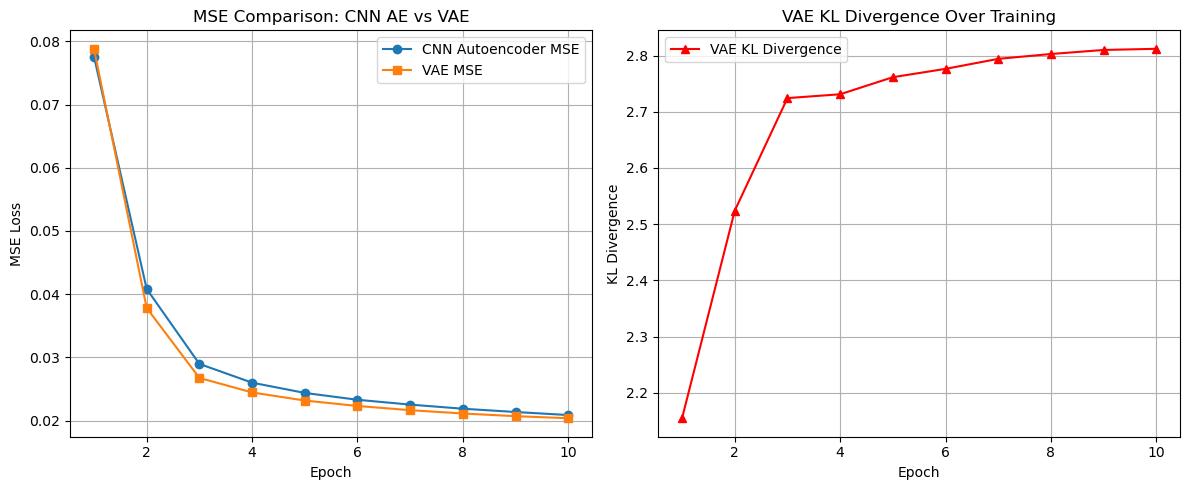


Final Results:
CNN Autoencoder final MSE: 0.0209
VAE final MSE: 0.0204
VAE final KL: 2.8120


In [28]:
if __name__ == "__main__":
    cnn_model, vae_model, data_loader = compare_models()

## Empirically show that the Variational Autoencoder features are more efficient in terms of size

In [30]:
def compare_efficiency():    
    unnormalized_dataset = create_unnormalized_dataset()
    BATCH_SIZE = 256
    unnormalized_loader = torch.utils.data.DataLoader(
        dataset=unnormalized_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=4
    )
    
    latent_dims = [2, 4, 8, 16]
    EPOCHS = 5   
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    cnn_results = []
    vae_results = []
    
    for dim in latent_dims:
        print(f"\n=== Testing Latent Dimension: {dim} ===")
        
        # Train CNN Autoencoder
        print(f"Training CNN Autoencoder (latent_dim={dim})...")
        cnn_model = CNNAutoencoderUnnormalized(latent_dim=dim)
        cnn_loss = train_cnn_autoencoder(cnn_model, unnormalized_loader, epochs=EPOCHS, device=device)
        cnn_final_loss = cnn_loss[-1]
        cnn_results.append((dim, cnn_final_loss))
        
        # Train VAE
        print(f"Training VAE (latent_dim={dim})...")
        vae_model = VAE(latent_dim=dim)
        vae_mse, vae_kl = train_vae(vae_model, unnormalized_loader, epochs=EPOCHS, beta=0.001, device=device)
        vae_final_loss = vae_mse[-1]
        vae_results.append((dim, vae_final_loss))
        
        print(f"Results for latent_dim={dim}:")
        print(f"  CNN AE final MSE: {cnn_final_loss:.4f}")
        print(f"  VAE final MSE: {vae_final_loss:.4f}")
        print(f"  VAE advantage: {((cnn_final_loss - vae_final_loss) / cnn_final_loss * 100):.1f}%")
    
    # Plot  
    plt.figure(figsize=(10, 6))
    
    dims, cnn_losses = zip(*cnn_results)
    dims, vae_losses = zip(*vae_results)
    
    plt.plot(dims, cnn_losses, 'o-', label='CNN Autoencoder', linewidth=2, markersize=8)
    plt.plot(dims, vae_losses, 's-', label='VAE', linewidth=2, markersize=8)
    
    plt.xlabel('Latent Dimension Size')
    plt.ylabel('Final MSE Loss')
    plt.title('Efficiency Comparison: VAE vs CNN Autoencoder')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  
    
    for i, dim in enumerate(dims):
        improvement = (cnn_losses[i] - vae_losses[i]) / cnn_losses[i] * 100
        plt.annotate(f'{improvement:.1f}%', 
                    xy=(dim, vae_losses[i]), 
                    xytext=(5, 10), 
                    textcoords='offset points',
                    fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    print("\n=== EFFICIENCY COMPARISON ===")
    print("Latent Dim | CNN AE MSE | VAE MSE    | VAE Improvement")
    print("-" * 55)
    for i, dim in enumerate(dims):
        improvement = (cnn_losses[i] - vae_losses[i]) / cnn_losses[i] * 100
        print(f"{dim:^10} | {cnn_losses[i]:^10.4f} | {vae_losses[i]:^10.4f} | {improvement:^13.1f}%")
    
    return cnn_results, vae_results


=== Testing Latent Dimension: 2 ===
Training CNN Autoencoder (latent_dim=2)...
[AE] Epoch 1, MSE: 0.0763
[AE] Epoch 2, MSE: 0.0567
[AE] Epoch 3, MSE: 0.0522
[AE] Epoch 4, MSE: 0.0500
[AE] Epoch 5, MSE: 0.0485
Training VAE (latent_dim=2)...
[VAE] Epoch 1, Total Loss: 0.0856, MSE: 0.0825, KL: 3.1001
[VAE] Epoch 2, Total Loss: 0.0573, MSE: 0.0549, KL: 2.3671
[VAE] Epoch 3, Total Loss: 0.0541, MSE: 0.0516, KL: 2.4154
[VAE] Epoch 4, Total Loss: 0.0525, MSE: 0.0500, KL: 2.4421
[VAE] Epoch 5, Total Loss: 0.0510, MSE: 0.0486, KL: 2.4619
Results for latent_dim=2:
  CNN AE final MSE: 0.0485
  VAE final MSE: 0.0486
  VAE advantage: -0.2%

=== Testing Latent Dimension: 4 ===
Training CNN Autoencoder (latent_dim=4)...
[AE] Epoch 1, MSE: 0.0795
[AE] Epoch 2, MSE: 0.0457
[AE] Epoch 3, MSE: 0.0415
[AE] Epoch 4, MSE: 0.0395
[AE] Epoch 5, MSE: 0.0380
Training VAE (latent_dim=4)...
[VAE] Epoch 1, Total Loss: 0.0941, MSE: 0.0916, KL: 2.5506
[VAE] Epoch 2, Total Loss: 0.0512, MSE: 0.0488, KL: 2.3850
[VAE]

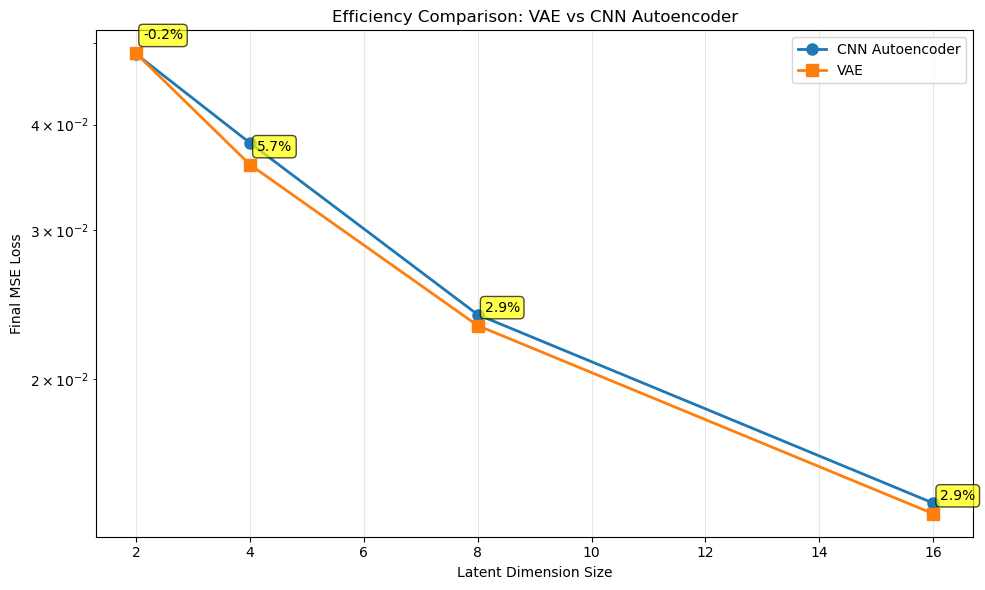


=== EFFICIENCY COMPARISON ===
Latent Dim | CNN AE MSE | VAE MSE    | VAE Improvement
-------------------------------------------------------
    2      |   0.0485   |   0.0486   |     -0.2     %
    4      |   0.0380   |   0.0359   |      5.7     %
    8      |   0.0238   |   0.0231   |      2.9     %
    16     |   0.0143   |   0.0139   |      2.9     %


In [31]:
cnn_results, vae_results = compare_efficiency()